In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from geopy.distance import geodesic
from quetzal.model import stepmodel
from quetzal.io.display import all_pt_paths, path, pt_path

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
# Load the network model from the last exercise
model_path = '../../model/'
sm = stepmodel.read_json(model_path + 'network')

In [3]:
# How many zones do we have?
len(sm.zones)

110

## Preparation of OD-times

The pathfinders need a column "time" in the links or road_links tables to find the shortest paths. The PT pathfinder also applies a generalized boarding time (can be interpreted as a penalty for interchanging between transport carriers) and a waiting time, which is computed from the headway of PT carriers (waiting time equals half the headway (in seconds) assuming a randomly and evenly distributed arrival pattern of passengers on every PT stop).

In [4]:
sm.road_links.sample(1)

,a,b,length,geometry,highway
index,,,,,
25657,368139,26401818,46.83,"LINESTRING (2.36655 48.85354, 2.36717 48.85345)",tertiary


In [5]:
sm.links.sample(1)

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,route_color,disaggregated_a,disaggregated_b,geometry
index,,,,,,,,,,,,,,,,
link_1670,100100061:61_0,n_129,n_44,9,60.0,600.0,100100061:61_0,100100061:61,6706,0,442,bus,00643C,node_StopPoint:59:4459263,node_StopPoint:59:4459264,"LINESTRING (2.37731 48.85310, 2.37870 48.85546)"


In [6]:
# We don't see any length column in our links,
# but it is nice for calculating speeds and for later steps.
# We can cast the PT network onto the road network (as in A40)
# Start with the bus links
bus = sm.copy() # copy the whole model
bus.links = bus.links.loc[bus.links['route_type'].isin(['bus'])] # Filter
# Apply quetzal's casting function
bus.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

100100096:96_1: 100%|████████████████████████████████████████████████████████████████| 212/212 [00:31<00:00,  6.75it/s]


In [7]:
bus.links.sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,...,route_type,route_color,disaggregated_a,disaggregated_b,road_a,road_b,road_node_list,road_link_list,road_length,geometry
index,,,,,,,,,,,,,,,,,,,,,
link_263,100100026:26_0,n_62,n_234,1,120.0,514.0,100100026:26_0,100100026:26,6706,1,...,bus,FF5A00,node_StopPoint:59:7899174,node_StopPoint:59:7170668,390060,707883928,"[390060, 368012, 368003, 368061, 15378859, 153...","[22048, 22044, 22067, 22821, 7215, 7208, 9632,...",751.901,"LINESTRING (2.3958129 48.8477806, 2.39573 48.8..."


In [8]:
# Now take the road_length of casted model as the length of our genuine model
sm.links['length'] = np.nan # create a new column with default values
sm.links.loc[sm.links['route_type'].isin(['bus']),
             'length'] = bus.links['road_length']

In [9]:
# For rail links, we can assign the geometric distance
sm.links.loc[sm.links['length'].isna(), 'length'] = \
    sm.links.loc[sm.links['length'].isna(), 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))
# Take the geometric line and from it the start and end points, then calculate the meter distance in between

In [10]:
# You can calculate the average bus operation speed
bus = sm.links.loc[sm.links['route_type'] == 'bus'] # filter
bus_lines = bus.groupby('route_id')[['time', 'length']].sum() # sum up time and length for each route
bus_speed = bus['length'].sum() / bus['time'].sum() # operation speed
print('bus_speed =', bus_speed, 'm / s')

bus_speed = 6.011094464749838 m / s


In [11]:
# Create the time LoS column for cars (it's already there for PT from the GTFS feeds)
car_speed = bus_speed * 1.25
sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s

In [12]:
# If we want to compute walking paths on road links, we need a time for that to
sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walk three times slower than car

## Pathfinding

Next, we want to create a table of OD-relations for different modes, each, being representative for the performance of a specific mode on a specific OD pair.

Quetzal has multiple options for path finding, seperated into one function wrapper for road and one for PT. They create the `car_los` and `pt_los tables`, respectively.

For road transport, quetzal can simply compute one shortest path per OD pair or multiple ones if you had the capacities and volumes already saved in the model (comes from the assignment step at the very end). So, we just compute one path for now (`all_or_nothing=True`)

The PT pathfinder has two relevant attributes: `broken_modes` and `broken_routes`. If both are `False`, the pathfinder just searches for the shortest path between every OD pair, considering all PT modes and routes. If `broken_modes=True`, the pathfinder searches shortest paths for every possible mode combination. If `broken_routes=True`, the pathfinder searches shortest paths for every possible route combination. 
Additionally you can decide whether walking connections shall be done on roadsides or not with the `walk_on_road` parameter (question of computation time).

### Car

In [13]:
# Simple road pathfinder
sm.step_road_pathfinder(all_or_nothing=True)

In [14]:
len(sm.car_los)

12100

In [15]:
sm.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs
6897,zone_56,zone_7,692.362284,"[zone_56, 141609493, 568456757, 7280346478, 56...","[141609493, 568456757, 7280346478, 568456506, ...","[12126, 18510, 11329, 18385, 10596, 10769, 109...","[(zone_56, 141609493), (2043615250, zone_7)]"


In [16]:
# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = sm.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
sm.car_los['length'] = sm.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

In [17]:
# add the route type for sake of consistency
sm.analysis_car_route_type()

In [18]:
sm.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
10355,zone_85,zone_13,554.794963,"[zone_85, 27234189, 3628689047, 5553992069, 19...","[27234189, 3628689047, 5553992069, 1987617271,...","[26153, 16276, 8414, 21028, 21070, 21103, 2655...","[(zone_85, 27234189), (227158606, zone_13)]",3706.275,"(car,)",car


### PT

In [23]:
# Simple PT
sm.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=False)

path_analysis: 100%|██████████████████████████████████████████████████████████| 12100/12100 [00:00<00:00, 49525.08it/s]


In [24]:
len(sm.pt_los)

12100

In [29]:
sm.pt_los.sample()

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
5902,zone_48,zone_65,1733.122155,"(zone_48, n_73, link_4976, link_4977, link_497...",best_path,False,"[n_73, n_258]","[n_258, n_231]","[n_73, n_258, n_231]","[link_4976, link_4977, link_4978, link_4979, l...",[],"[(zone_48, n_73), (n_231, zone_65)]",[n_258],"[link_4976, link_4364]","[link_4980, link_4364]",False,1,720.0,9608.0


In [30]:
sm.pt_los.columns

Index(['origin', 'destination', 'gtime', 'path', 'pathfinder_session',
       'reversed', 'boardings', 'alightings', 'node_path', 'link_path',
       'footpaths', 'ntlegs', 'transfers', 'boarding_links', 'alighting_links',
       'all_walk', 'ntransfers', 'time_link_path', 'length_link_path'],
      dtype='object')

In [31]:
sm.links['route_type'].unique()

array(['bus', 'subway', 'tram', 'rail'], dtype=object)

In [32]:
# Add route types to the paths
# The mode that appears first in the hierarchy is assigned as
# main mode, if there is more than one route_type used on the path
hierarchy = ['rail', 'subway', 'funicular', 'tram', 'bus']
sm.analysis_pt_route_type(hierarchy)

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

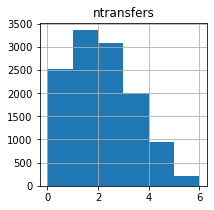

In [33]:
# How many transfers do we have?
sm.pt_los.hist(column='ntransfers', bins=6, figsize=(3,3))

<AxesSubplot:xlabel='route_types'>

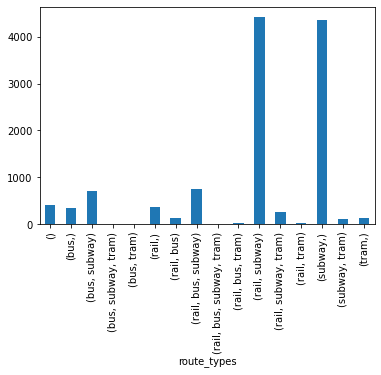

In [34]:
# How many connections do we have per mode combination in the shortest paths?
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple) # bugfix
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

In [35]:
# Now, let's look at the results when we disaggregate paths by route_type
sm.step_pt_pathfinder(broken_modes=True, broken_routes=False, walk_on_road=False)

path_analysis: 100%|██████████████████████████████████████████████████████████| 73090/73090 [00:01<00:00, 47226.79it/s]


In [36]:
# How many paths do we have now compared to 12,100 before?
len(sm.pt_los)

73090

In [37]:
sm.analysis_pt_route_type(hierarchy)
sm.pt_los.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,route_types,route_type
3673,zone_3,zone_39,2063.545947,"(zone_3, n_190, link_5012, link_5013, n_62, n_...",False,mode_breaker,"{bus, subway, tram}",[n_190],[n_62],"[n_190, n_62, n_23]",...,"[(zone_3, n_190), (n_23, zone_39)]",[],[link_5012],[link_5013],False,0,240.0,6015.0,"(rail,)",rail


<AxesSubplot:xlabel='route_types'>

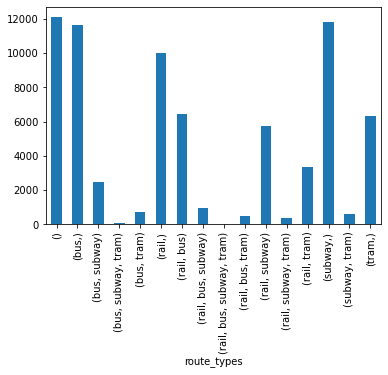

In [38]:
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple) # bugfix
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

In [39]:
# Compute time attribute (from link path and footpaths and access links)
sm.analysis_pt_time()

In [40]:
# Closer look at one OD pair
sm.pt_los.loc[(sm.pt_los['origin']=='zone_11') & (sm.pt_los['destination']=='zone_99')][
    ['route_types', 'time', 'ntransfers']]

,route_types,time,ntransfers
1539,(),6159.900608,0
1539,"(subway,)",1625.229715,3
1539,"(rail,)",1446.854030,1
1539,"(bus,)",2101.908185,1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]


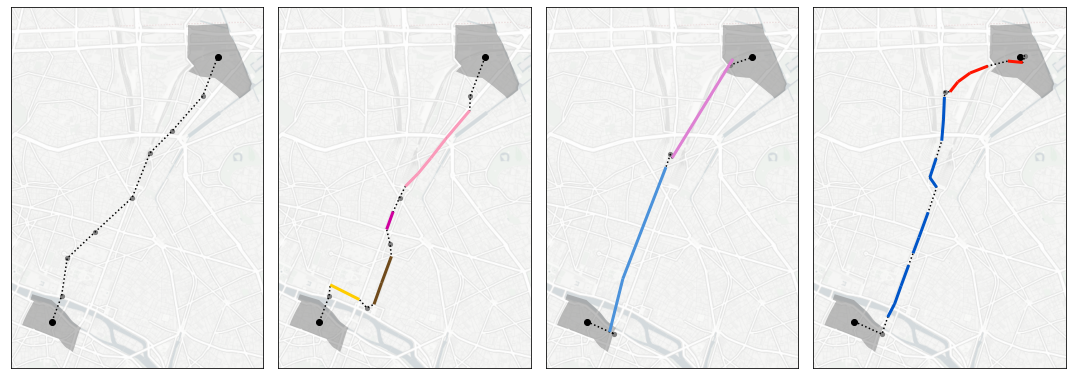

In [41]:
# Plot
plot = sm.change_epsg(3857, coordinates_unit=sm.coordinates_unit)
plot.links['color'] = '#' + plot.links['route_color']
fig, axes = plot.plot_separated_paths(
    'zone_11', 'zone_99', rows=1, figsize=[16, 16],
    title=None, constrained_layout=True, zoom=13, resize=True,
    basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', 
)

In [42]:
# Assign a length to LoS table
sm.analysis_pt_length()

<AxesSubplot:>

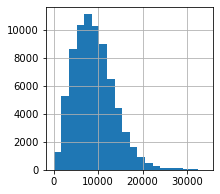

In [43]:
# Length distribution
sm.pt_los['length'].hist(bins=20, figsize=(3,3))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

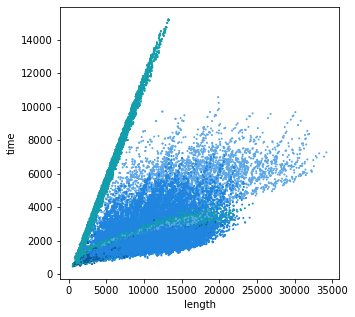

In [56]:
# Dependency between distance and time
mask = sm.pt_los['origin']!=sm.pt_los['destination'] # Filter statement
color_dict = {'bus': '#129eac', 'subway': '#0e5899', 'tram': '#5ea8e8', 'rail': '#1F85DE', 'walk': '#adb3b4'}
color_list = [color_dict[t] for t in sm.pt_los.loc[mask, 'route_type']]
ax = sm.pt_los.loc[mask].plot(
    kind='scatter', x='length', y='time', figsize=[5, 5], s=1, c=color_list)
ax.legend(handles=color_list, labels=sm.pt_los.loc[mask, 'route_type'])

In [50]:
# Plot all paths between zones including car
path(sm, 'zone_1', 'zone_99', public=True, private=True)

## Prices

Add price LoS attribute to LoS tables

In [51]:
# Car usage has operating cost of 12ct/km in average
# Note: we don't apply sunk cost like maintenance or purchase cost
sm.car_los['price'] = sm.car_los['length'] * 0.12 / 1000

In [52]:
# For PT, we have a look at the PT operators price structure.
# For this toy model we simplify it to day tickets:
# https://www.ratp.fr/en/titres-et-tarifs/mobilis
# Assume that a passenger makes two trips per day with a day ticket
sm.pt_los['price'] = 7.5 / 2
# We don't re-build the exact price structure, but make longer trips more expensive
sm.pt_los.loc[sm.pt_los['length']>10000, 'price'] = 10 / 2

## Save model

In [85]:
sm.to_json(model_path + 'los_tables')

to_hdf(overwriting):  71%|███████████████████████████████████████████▎                 | 27/38 [00:11<00:03,  3.32it/s]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes
could not save geometry from table mode_nests
could not save geometry from table logit_scales
could not save geometry from table utility_values


to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:15<00:00,  2.50it/s]
